In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os


from sklearn import metrics
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression



In [3]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
df_0 = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
df_1 = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

print('\n\nTotal Null values in Train: ', df_1.isnull().sum().sum())
print('Total Null values in original data: ', df_0.isnull().sum().sum())
print('\n\nTotal Null values in Test: ', test.isnull().sum().sum())




Total Null values in Train:  0
Total Null values in original data:  4011


Total Null values in Test:  0


I will combine the original dataset with the tabular dataset
- drop the id from the tabular dataset 
- drop the rows that have null values or 
    - if there is some relation between the featires i will impute something later on 

In [4]:
train = pd.concat((df_1.drop(columns = ['id'], inplace = False), df_0)).dropna(how='any',axis=0) 
test = test.drop(columns = ['id'])
print('train', train.shape, 'test', test.shape)

train (87283, 12) test (39098, 11)


All the unique values in the dataset
 -- person_home_ownership has: 4


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


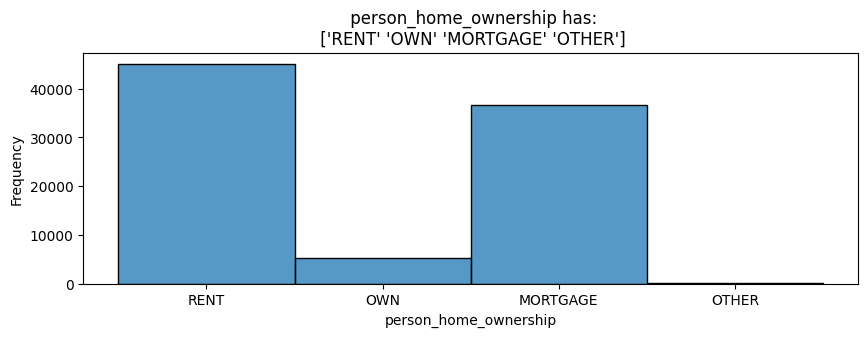




 -- loan_intent has: 6


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


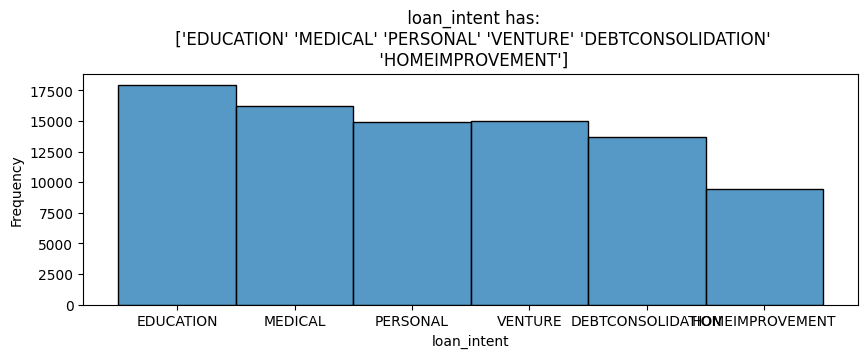




 -- loan_grade has: 7


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


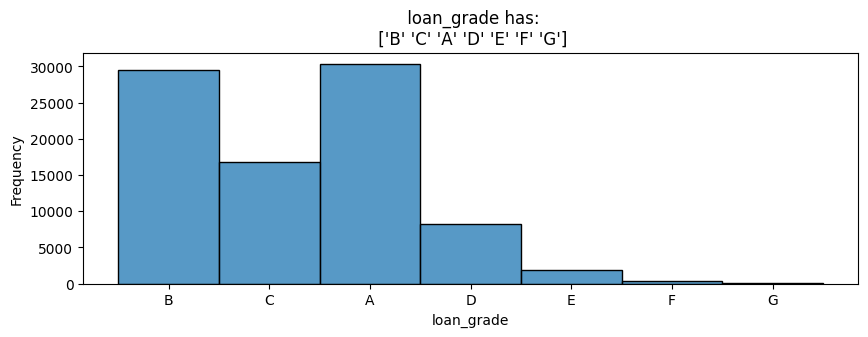




 -- cb_person_default_on_file has: 2


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


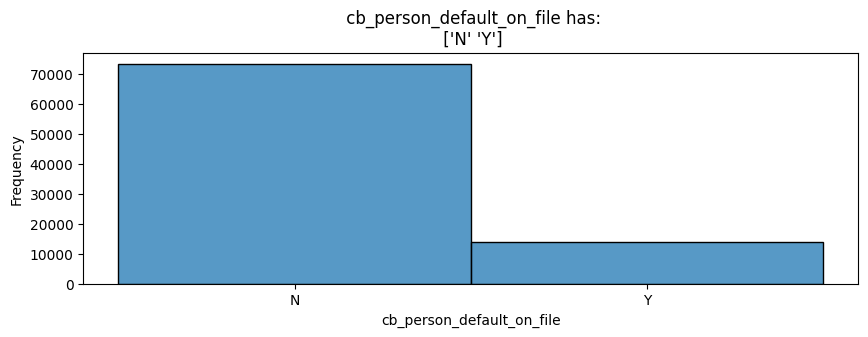

In [5]:
def uniqueValues(df):   
    object_cols = df.select_dtypes(include = ['object']).columns
    print('All the unique values in the dataset')
    for cols in object_cols:
        print(f" -- {cols} has: {df[cols].nunique()}")
        if df[f'{cols}'].nunique() > 1000000:
            print(f" -- {cols} has: {df[cols].nunique()}, too many to list")
        else:
            plt.figure(figsize=(10, 3))
            sns.histplot(df[cols], kde = False) #, bins = 5)
            plt.title(f" {cols} has:\n {df[cols].unique()}")
            plt.xlabel(f'{cols}')
            plt.ylabel('Frequency')
            plt.show()

        print('\n\n') 
        
uniqueValues(train)

## dealing with categorical variables

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
>>> df1 = pd.DataFrame([['a', 1], ['b', 2]],
...                    columns=['letter', 'number'])
>>> print(df1)

>>> df2 = pd.DataFrame([['c', 3], ['d', 4]],
...                    columns=['letter', 'number'])
>>> print(df2)

>>> pd.concat([df1, df2], axis = 1)


  letter  number
0      a       1
1      b       2
  letter  number
0      c       3
1      d       4


,letter,number,letter,number
0,a,1,c,3
1,b,2,d,4


In [8]:
def featureEncoding(df, _type = None):
    object_cols = df.select_dtypes(include = ['object']).columns
    
    if _type == 'one_hot':
        obj_df = pd.get_dummies(df[object_cols], drop_first=True, dtype='int8')
        combined_df = pd.concat([df.drop(columns = object_cols, axis = 1), obj_df], axis=1)
        
#     print(len(combined_df.columns))
        
    return combined_df


def featureScaling(df, _type = None):
    scaler = MinMaxScaler()
    
    if _type == 'train':
        x = df.drop(['loan_status'], axis = 1)
        cols = x.columns
        x = pd.DataFrame(scaler.fit_transform(x), columns = cols)
        return x, df['loan_status']
    elif _type == 'test':
        cols = df.columns
        x = pd.DataFrame(scaler.fit_transform(df), columns = cols)
        return x
    return 
    

x, y = featureScaling(featureEncoding(train, 'one_hot'), 'train')
test_df = featureScaling(featureEncoding(test, 'one_hot'), 'test')

## basic model testing 

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [10]:
def model_prediction(model, x_train, x_test, y_train, y_test):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)[:, 1]

    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    c = precision_score(y_test,x_test_pred)
    d = recall_score(y_test,x_test_pred)
    e = roc_auc_score(y_test, y_test_prob)
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print(f"Precision Score of {model} model is:",c)
    print(f"Recall Score of {model} model is:",d)
    print(f"AUC Score of {model} model is:", e)
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")
    plt.show()
    
    return model

def testSubmisison(test, submission, model):
    name = model.__class__.__name__
    submission['loan_status'] = model.predict(test)
    submission.to_csv(f'{name}_submission.csv', index = False)
    
    

Accuracy_Score of LogisticRegression() model on Training Data is: 89.78853644963829
Accuracy_Score of LogisticRegression() model on Testing Data is: 89.6123734962765
Precision Score of LogisticRegression() model is: 0.7688243064729194
Recall Score of LogisticRegression() model is: 0.5354185832566697
AUC Score of LogisticRegression() model is: 0.8879120133999421

------------------------------------------------------------------------
Confusion Matrix of LogisticRegression() model is:


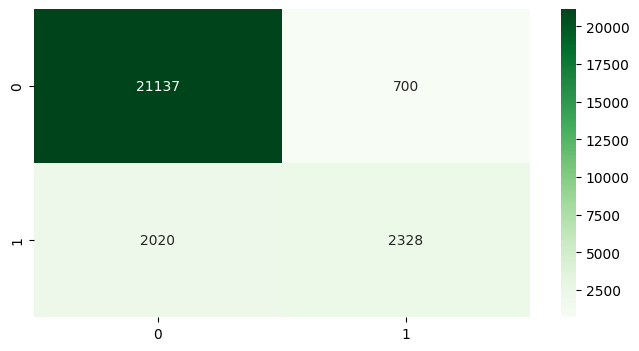

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
model = model_prediction(clf, x_train, x_test, y_train, y_test)
testSubmisison(test_df, sample_submission, model)

[LightGBM] [Info] Number of positive: 10205, number of negative: 50893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 61098, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167027 -> initscore=-1.606848
[LightGBM] [Info] Start training from score -1.606848
Accuracy_Score of LGBMClassifier() model on Training Data is: 94.93273102229206
Accuracy_Score of LGBMClassifier() model on Testing Data is: 94.72216918082871
Precision Score of LGBMClassifier() model is: 0.94058229352347
Recall Score of LGBMClassifier() model is: 0.7281508739650414
AUC Score of LGBMClassifier() model is: 0.9547559795185698

------------------------------------------------------------------------
Confusion Matrix of LGBMCl

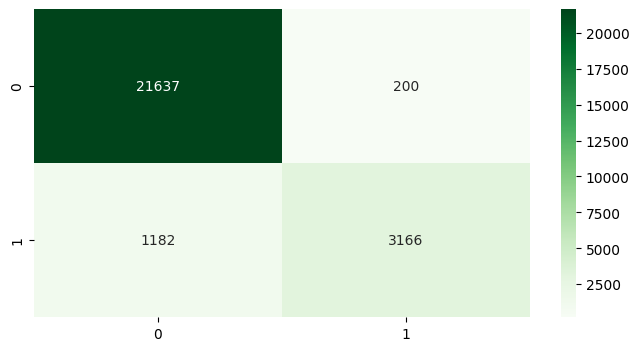

In [12]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
model = model_prediction(clf, x_train, x_test, y_train, y_test)
testSubmisison(test_df, sample_submission, model)

Accuracy_Score of RandomForestClassifier() model on Training Data is: 99.99672657042784
Accuracy_Score of RandomForestClassifier() model on Testing Data is: 94.58086690853543
Precision Score of RandomForestClassifier() model is: 0.934956934956935
Recall Score of RandomForestClassifier() model is: 0.7240110395584176
AUC Score of RandomForestClassifier() model is: 0.9349886456984822

------------------------------------------------------------------------
Confusion Matrix of RandomForestClassifier() model is:


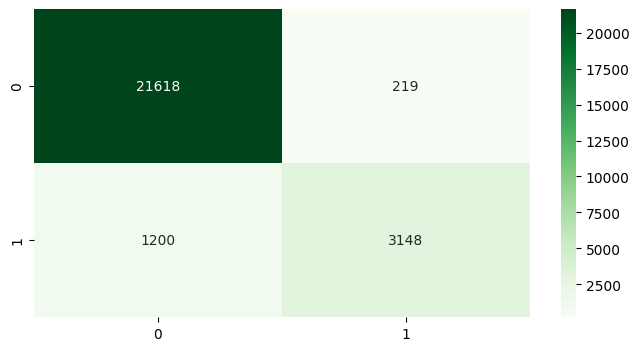

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)  
model = model_prediction(clf, x_train, x_test, y_train, y_test)
testSubmisison(test_df, sample_submission, model)